## 双目相机标定实验
学号：23103402  
姓名：丁悦林

棋盘格宽度25mm，内角点11*7

In [40]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 棋盘格双目标定

### 准备

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [41]:
class StereoCameraCalibrator:
    def __init__(self, left_img_dir, right_img_dir, corner_shape, size):
        # self.left_img_dir = left_img_dir
        # self.right_img_dir = right_img_dir
        self.corner_shape = corner_shape
        self.size = size
        
        # 左右相机内参、畸变系数、旋转和平移向量
        self.left_inner_matrix = None
        self.left_dis_coeff = None
        self.left_vector_r = None
        self.left_vector_t = None
        
        self.right_inner_matrix = None
        self.right_dis_coeff = None
        self.right_vector_r = None
        self.right_vector_t = None
        
        # 双目标定结果
        self.R = None
        self.T = None
        self.E = None # 本征矩阵
        self.F = None # 基础矩阵
        
        # 准备棋盘格世界坐标
        w,h = corner_shape
        # cp指corner points
        cp_int = np.zeros((w*h, 3), np.float32)
        cp_int[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2)
        self.cp_world = cp_int * size  # (w*h,3):每一行为(X,Y,Z)
        
        self.left_img_paths = sorted(glob.glob(os.path.join(left_img_dir, "*.png")))
        self.right_img_paths = sorted(glob.glob(os.path.join(right_img_dir, "*.png")))
        assert len(self.left_img_paths), "左相机图像路径加载失败"
        assert len(self.right_img_paths), "右相机图像路径加载失败"
        assert len(self.left_img_paths) == len(self.right_img_paths), "左右相机图像数量不同"
    
    def _find_corners(self):
        """
        在左右相机图像中检测角点
        """
        w,h = self.corner_shape
        
        points_world = []
        left_points_pixel = [] # 存储像素坐标
        right_points_pixel = []
        left_imgs_with_corners = []
        right_imgs_with_corners = []
        img_size = None
        
        print(f"开始处理{len(self.left_img_paths)}对图像")
        
        for idx, (left_path,right_path) in enumerate(zip(self.left_img_paths, self.right_img_paths)):
            left_img = cv2.imread(left_path)
            right_img = cv2.imread(right_path)
            left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
            right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
            
            # 这个img_size指的是图像的宽度和高度，双目相机通常是两个完全相同的摄像头
            if img_size is None: # 这里img_size图像标定的时候会用到
                img_size = left_gray.shape[::-1]
            
            # 检测左图角点
            ret_left, cp_left = cv2.findChessboardCorners(left_gray, (w, h), None)
            # 检测右图角点
            ret_right, cp_right = cv2.findChessboardCorners(right_gray, (w, h), None)
            
            if ret_left and ret_right:
                # 亚像素角点精细化
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                # 得到角点的像素坐标
                cp_left = cv2.cornerSubPix(left_gray, cp_left, (11, 11), (-1, -1), criteria)
                cp_right = cv2.cornerSubPix(right_gray, cp_right, (11, 11), (-1, -1), criteria)
                
                points_world.append(self.cp_world)
                left_points_pixel.append(cp_left)
                right_points_pixel.append(cp_right)
                
                # 准备可视化
                left_img_corners = left_img.copy()
                right_img_corners = right_img.copy()
                cv2.drawChessboardCorners(left_img_corners, (w, h), cp_left, ret_left)
                cv2.drawChessboardCorners(right_img_corners, (w, h), cp_right, ret_right)
                
                left_imgs_with_corners.append(cv2.cvtColor(left_img_corners, cv2.COLOR_BGR2RGB))
                right_imgs_with_corners.append(cv2.cvtColor(right_img_corners, cv2.COLOR_BGR2RGB))
            else:
                print(f"第{idx+1}对图像角点检测失败")
        
        return points_world, left_points_pixel, right_points_pixel, \
               left_imgs_with_corners, right_imgs_with_corners, img_size
    
    def _visualize_corners(self, left_imgs_with_corners, right_imgs_with_corners):
        """
        可视化左右相机的角点检测结果
        """
        n_images = len(left_imgs_with_corners)
        cols = min(5, n_images)
        rows = (n_images+cols-1) // cols
        
        fig_left = plt.figure(figsize=(5*cols, 4*rows))
        for idx,img in enumerate(left_imgs_with_corners):
            ax = fig_left.add_subplot(rows, cols, idx+1)
            ax.imshow(img)
            ax.set_title(f"左{idx+1}", fontsize=15)
            ax.axis('off')
        plt.tight_layout()
        plt.suptitle("左相机角点检测结果", fontsize=15, y=1.00)
        plt.show()
        
        fig_right = plt.figure(figsize=(5*cols, 4*rows))
        for idx,img in enumerate(right_imgs_with_corners):
            ax = fig_right.add_subplot(rows, cols, idx+1)
            ax.imshow(img)
            ax.set_title(f"右{idx+1}", fontsize=15)
            ax.axis('off')
        plt.tight_layout()
        plt.suptitle("右相机角点检测结果", fontsize=15, y=1.00)
        plt.show()
    
    def stereo_calibrate_camera(self,flags=cv2.CALIB_USE_INTRINSIC_GUESS,visualize=False):
        """
        执行双目相机标定
        默认flags使用两步优化策略:
        1. 先分别对左右相机进行单目标定，获得初始内参和畸变系数
        2. 使用初始值进行双目联合优化，获得最终的内参和相对位姿
        """
        
        # 检测角点
        points_world, left_points_pixel, right_points_pixel, \
        left_imgs_corners, right_imgs_corners, img_size = self._find_corners()
        if len(points_world) == 0:
            raise ValueError("没有检测到有效的角点")
        
        if visualize:
            self._visualize_corners(left_imgs_corners, right_imgs_corners)
        
        # 左右相机单目标定
        left_mtx,left_dist,left_rvecs,left_tvecs,right_mtx,right_dist,right_rvecs,right_tvecs = None,None,None,None,None,None,None,None
        if flags != 0:
            ret_left, left_mtx, left_dist, left_rvecs, left_tvecs = cv2.calibrateCamera(
                points_world, left_points_pixel, img_size, None, None
            )
            # print(f"左相机重投影误差:{ret_left:.4f}像素")
            ret_right, right_mtx, right_dist, right_rvecs, right_tvecs = cv2.calibrateCamera(
                points_world, right_points_pixel, img_size, None, None
            )
            # print(f"右相机重投影误差:{ret_right:.4f}像素")
        
        # 双目标定
        criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)
        ret_stereo, left_mtx_final, left_dist_final, right_mtx_final, right_dist_final, \
        R, T, E, F = cv2.stereoCalibrate(
            points_world, left_points_pixel, right_points_pixel,
            left_mtx, left_dist, # 左右相机内参和畸变系数的初值
            right_mtx, right_dist,
            img_size,
            criteria=criteria_stereo,
            flags=flags
        )
        print(f"双目联合标定重投影误差:{ret_stereo:.4f}像素")
        
        # 保存标定结果
        self.left_inner_matrix = left_mtx_final
        self.left_dis_coeff = left_dist_final
        self.left_vector_r = left_rvecs
        self.left_vector_t = left_tvecs
        
        self.right_inner_matrix = right_mtx_final
        self.right_dis_coeff = right_dist_final
        self.right_vector_r = right_rvecs
        self.right_vector_t = right_tvecs
        
        self.R = R
        self.T = T
        self.E = E
        self.F = F

        return ret_stereo, left_mtx_final, left_dist_final, \
               right_mtx_final, right_dist_final, R, T, E, F

In [42]:
left_img_dir = "../data/imgs/leftcamera"
right_img_dir = "../data/imgs/rightcamera"
corner_shape = (11,7)
size = 0.025

### 对比实验

In [43]:
stero_cammera_calibrator = StereoCameraCalibrator(left_img_dir,right_img_dir,corner_shape,size)
flags1 = 0 # 不依赖初值，重新计算
flags2 = cv2.CALIB_FIX_INTRINSIC # 完全固定输入的内参和畸变系数
flags3 = cv2.CALIB_USE_INTRINSIC_GUESS # 使用输入的内参和畸变系数作为优化的初值
result = {}

In [44]:
result['flags1'] = stero_cammera_calibrator.stereo_calibrate_camera(flags=flags1)

开始处理20对图像
双目联合标定重投影误差:0.2033像素


In [45]:
result['flags2'] = stero_cammera_calibrator.stereo_calibrate_camera(flags=flags2)

开始处理20对图像
双目联合标定重投影误差:0.2052像素


In [46]:
result['flags3'] = stero_cammera_calibrator.stereo_calibrate_camera(flags=flags3)

开始处理20对图像
双目联合标定重投影误差:0.2033像素


可以看到，数据质量较好，三种计算方式的差距不大。

### 绘制极线

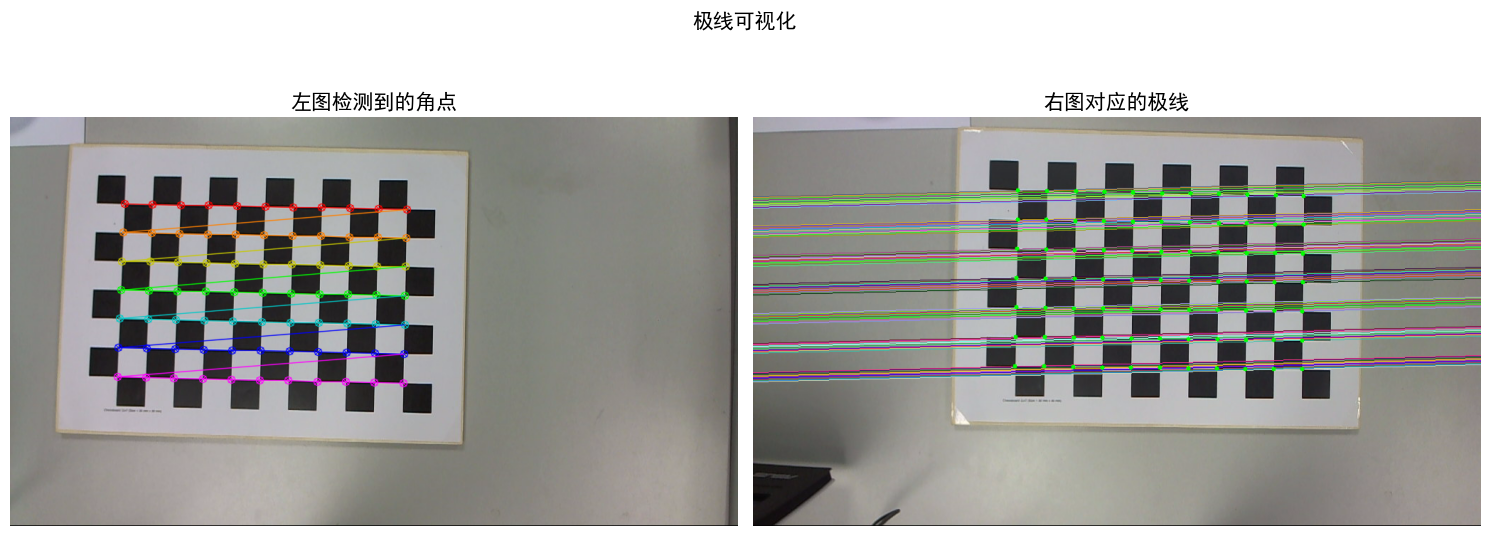

成功绘制了77条极线


In [47]:
# 使用flags3的标定结果绘制极线
F = stero_cammera_calibrator.F

# 取第一对图像
left_img_first = cv2.imread(stero_cammera_calibrator.left_img_paths[0])
right_img_first = cv2.imread(stero_cammera_calibrator.right_img_paths[0])
left_gray_first = cv2.cvtColor(left_img_first, cv2.COLOR_BGR2GRAY)
right_gray_first = cv2.cvtColor(right_img_first, cv2.COLOR_BGR2GRAY)

w, h = stero_cammera_calibrator.corner_shape

# 先在左图找点
ret_left, left_corners = cv2.findChessboardCorners(left_gray_first, (w, h), None)
if ret_left:
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    left_corners = cv2.cornerSubPix(left_gray_first, left_corners, (11, 11), (-1, -1), criteria)
    # 在左图上绘制角点
    left_img_with_corners = left_img_first.copy()
    cv2.drawChessboardCorners(left_img_with_corners, (w, h), left_corners, ret_left)

    # 计算左图角点对应的极线
    lines_right = cv2.computeCorrespondEpilines(left_corners.reshape(-1, 1, 2), 1, F) # 参数1表示输入点来自左图
    lines_right = lines_right.reshape(-1, 3) # (a,b,c) ax+by+c=0
    
    # 在右图上绘制极线
    right_img_with_lines = right_img_first.copy()
    h_img, w_img = right_img_with_lines.shape[:2]
    for line in lines_right: # 数学运算
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = 0, int(-line[2]/line[1])
        x1, y1 = w_img-1, int(-(line[2] + line[0]*(w_img-1))/line[1])
        cv2.line(right_img_with_lines, (x0, y0), (x1, y1), color, 1) # 画线
    
    # 验证：在右图上绘制对应的角点
    ret_right, right_corners = cv2.findChessboardCorners(right_gray_first, (w, h), None)
    if ret_right:
        right_corners = cv2.cornerSubPix(right_gray_first, right_corners, (11, 11), (-1, -1), criteria)
        for corner in right_corners:
            cv2.circle(right_img_with_lines, tuple(corner[0].astype(int)), 3, (0, 255, 0), -1)

    # 可视化结果
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(cv2.cvtColor(left_img_with_corners, cv2.COLOR_BGR2RGB))
    axes[0].set_title('左图检测到的角点', fontsize=15)
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(right_img_with_lines, cv2.COLOR_BGR2RGB))
    axes[1].set_title('右图对应的极线', fontsize=15)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('极线可视化', fontsize=15, y=1.02)
    plt.show()
    
    print(f"成功绘制了{len(lines_right)}条极线")
else:
    print("左图角点检测失败")

### 总结
- 单目相机标定：
  棋盘格相对单目相机移动。拍摄N张图，每一张图棋盘格对于相机的位姿不同，所以会有N组旋转矩阵和平移向量。

- 双目标定：
  双目左右相机的相对位姿固定，旋转矩阵R和平移向量T只有一组，表示左右相机的相对位姿

## 街景场景下对极几何估计

In [27]:
left_street_img = cv2.imread('../data/L.png')
right_street_img = cv2.imread('../data/R.png')
if left_street_img is None or right_street_img is None:
    print("X")

In [29]:
left_gray = cv2.cvtColor(left_street_img, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_street_img, cv2.COLOR_BGR2GRAY)

# SIFT特征提取
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_gray, None)
kp2, des2 = sift.detectAndCompute(right_gray, None)

# FLANN特征匹配
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 使用Lowe's比值测试筛选好的匹配点
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"检测到{len(kp1)}个左图特征点，{len(kp2)}个右图特征点")
print(f"筛选后得到{len(good_matches)}个有效匹配点")

检测到4135个左图特征点，3967个右图特征点
筛选后得到958个有效匹配点


In [30]:
if len(good_matches) >= 8: # 至少需要8个点估计基础矩阵
    # 提取匹配点的坐标
    left_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    right_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # 计算基础矩阵F，使用RANSAC剔除误匹配
    F_street, mask = cv2.findFundamentalMat(left_pts, right_pts, cv2.FM_RANSAC, 3.0, 0.99)
    
    # 提取内点
    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
    print(f"RANSAC剔除后保留{len(inlier_matches)}个内点")
    
else:
    print("匹配点数量不足8个，无法计算F")
    F_street = None

RANSAC剔除后保留918个内点


In [37]:
if F_street is not None:
    # 取前25个用于可视化
    # mask.ravel() == 1 用于筛选内点
    selector = mask.ravel() == 1
    selected_left_pts = left_pts[selector][:25]
    selected_right_pts = right_pts[selector][:25]  # 获取对应的右图点
    
    # 计算极线
    lines_right = cv2.computeCorrespondEpilines(selected_left_pts.reshape(-1, 1, 2), 1, F_street)
    lines_right = lines_right.reshape(-1, 3) # (a,b,c)

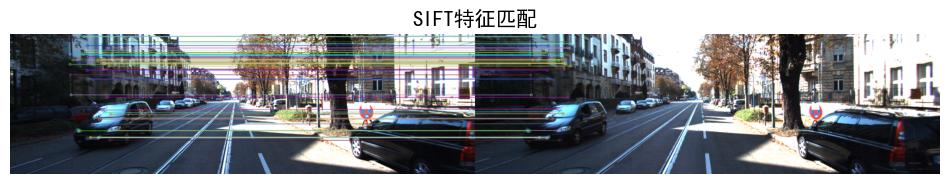

In [38]:
plt.figure(figsize=(12, 6))

# 绘制前50个点的匹配连线
match_img = cv2.drawMatches(left_street_img, kp1, right_street_img, kp2, 
                           inlier_matches[:50], None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT特征匹配', fontsize=15)
plt.axis('off')
plt.show()

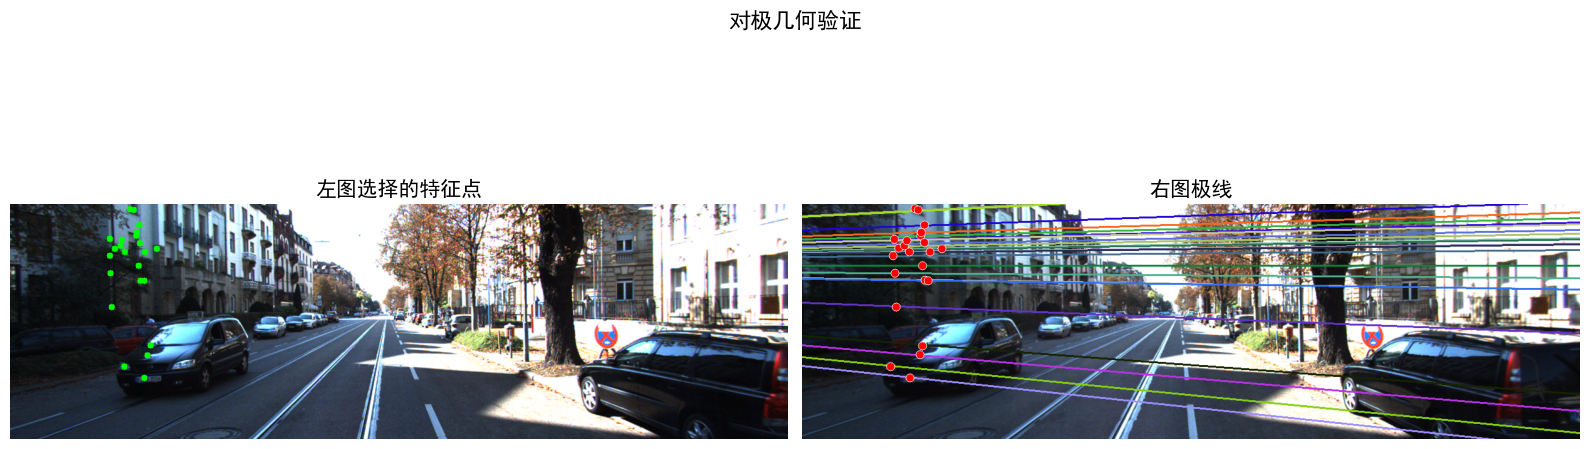

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图画特征点
left_with_points = left_street_img.copy()
for pt in selected_left_pts:
    cv2.circle(left_with_points, tuple(pt[0].astype(int)), 5, (0, 255, 0), -1)
axes[0].imshow(cv2.cvtColor(left_with_points, cv2.COLOR_BGR2RGB))
axes[0].set_title('左图选择的特征点', fontsize=15)
axes[0].axis('off')

# 处理右图
right_with_lines = right_street_img.copy()
h_img, w_img = right_with_lines.shape[:2]

# 右图画极线
for line in lines_right:
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = 0, int(-line[2]/line[1]) if line[1] != 0 else 0
    x1, y1 = w_img-1, int(-(line[2] + line[0]*(w_img-1))/line[1]) if line[1] != 0 else h_img-1
    cv2.line(right_with_lines, (x0, y0), (x1, y1), color, 2)

# 在右图中画出对应的特征点
for pt in selected_right_pts:
    cv2.circle(right_with_lines, tuple(pt[0].astype(int)), 6, (0, 0, 255), -1)
    cv2.circle(right_with_lines, tuple(pt[0].astype(int)), 7, (255, 255, 255), 1)

axes[1].imshow(cv2.cvtColor(right_with_lines, cv2.COLOR_BGR2RGB))
axes[1].set_title('右图极线', fontsize=15)
axes[1].axis('off')

plt.tight_layout()
plt.suptitle('对极几何验证', fontsize=16, y=1.02)
plt.show()

较为精确，特征点都落在了极线上